In [3]:
%run '../data_preparation.ipynb'

Number of finding labels: 16297
['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']
Labels (7) [('Atelectasis', 692), ('Effusion', 700), ('Infiltration', 2292), ('Mass', 310), ('Nodule', 441), ('Pleural_Thickening', 207), ('Pneumothorax', 445)]


In [4]:
# Splitting data into training and validation sets.
from sklearn.model_selection import train_test_split
training_df, validation_df = train_test_split(xray_labels_df, 
                                              test_size = 0.25, 
                                              random_state = 2018,
                                              stratify = xray_labels_df['Finding Labels'].map(lambda x: x[:4]))

print('train', training_df.shape[0], 'validation', validation_df.shape[0])

train 6000 validation 2000


In [5]:
from keras.preprocessing.image import ImageDataGenerator
IMG_SIZE = (128, 128)
core_idg = ImageDataGenerator(samplewise_center=True,
                              samplewise_std_normalization=True,
                              horizontal_flip=True,
                              vertical_flip=True,
                              height_shift_range=0.05,
                              width_shift_range=0.1,
                              rotation_range=5,
                              shear_range=0.1,
                              fill_mode='reflect',
                              zoom_range=0.15)

/anaconda3/envs/csc665/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [6]:
def flow_from_dataframe(img_data_gen, in_df, path_col, y_col, **dflow_args):
    base_dir = os.path.dirname(in_df[path_col].values[0])
    
    df_gen = img_data_gen.flow_from_directory(base_dir, class_mode='sparse', **dflow_args)
    df_gen.filenames = in_df[path_col].values
    df_gen.classes = np.stack(in_df[y_col].values)
    df_gen.samples = in_df.shape[0]
    df_gen.n = in_df.shape[0]
    df_gen._set_index_array()
    df_gen.directory = ''
    print('Reinserting dataframe: {} images'.format(in_df.shape[0]))
    
    # df_gen is an iterator that yields a tuple (X,Y). 
    # X = batch of images, and Y = corresponding labels.
    return df_gen
    

In [7]:
# Generates training and validation data to be used by models.
training_gen = flow_from_dataframe(core_idg, training_df, path_col='path', y_col='disease_vec',target_size = IMG_SIZE, color_mode ='grayscale', batch_size = 32)
validation_gen = flow_from_dataframe(core_idg, validation_df, path_col='path', y_col='disease_vec',target_size = IMG_SIZE, color_mode ='grayscale', batch_size = 256)

test_X, test_Y = next(flow_from_dataframe(core_idg, validation_df, path_col ='path', y_col ='disease_vec', target_size = IMG_SIZE, color_mode = 'grayscale', batch_size = 1024))



Found 0 images belonging to 0 classes.
Reinserting dataframe: 6000 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images
Found 0 images belonging to 0 classes.
Reinserting dataframe: 2000 images


In [8]:
t_x, t_y = next(training_gen)

In [9]:
from keras.applications.mobilenet import MobileNet
from keras.layers import GlobalAveragePooling2D, Dense, Dropout, Flatten
from keras.models import Sequential
import tensorflow as tf

base_mobilenet_model = MobileNet(input_shape = t_x.shape[1:],
                                 include_top = False, weights = None)

multi_disease_model = Sequential()
multi_disease_model.add(base_mobilenet_model)
multi_disease_model.add(GlobalAveragePooling2D())
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(512))
multi_disease_model.add(Dropout(0.5))
multi_disease_model.add(Dense(len(all_labels), activation = 'relu'))
multi_disease_model.compile(optimizer = 'adam', loss ='binary_crossentropy',
                            metrics = ['binary_accuracy', 'mae'])
multi_disease_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228288   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 1024)              0         
_________________________________________________________________
dense_1 (Dense)              (None, 512)               524800    
_________________________________________________________________
dropout_2 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_2 (Dense)              (None, 7)                 3591      
Total params: 3,756,679
Trainable params: 3,734,791
Non-trainable params: 21,888
_____________________________________________________________

In [10]:
from keras.callbacks import ModelCheckpoint, LearningRateScheduler, EarlyStopping, ReduceLROnPlateau

weight_path = "{}_weights_relu_128x128.best.hdf5".format("xray_class")

checkpoint = ModelCheckpoint(weight_path, monitor='val_loss', verbose=1, 
                             save_best_only=True, mode='min', save_weights_only = True)

early = EarlyStopping(monitor="val_loss", 
                      mode="min", 
                      patience=3)
callbacks_list = [checkpoint, early]

In [11]:
multi_disease_model.fit_generator(training_gen, 
                                  steps_per_epoch=100,
                                  validation_data = (test_X, test_Y), 
                                  epochs = 1, 
                                  callbacks = callbacks_list)

Epoch 1/1
100/100 [==============================] - 536s 5s/step - loss: 1.4788 - binary_accuracy: 0.9071 - mean_absolute_error: 0.0952 - val_loss: 1.4886 - val_binary_accuracy: 0.9076 - val_mean_absolute_error: 0.0924

Epoch 00001: val_loss improved from inf to 1.48859, saving model to xray_class_weights_relu_128x128.best.hdf5


In [13]:
multi_disease_model.load_weights(weight_path)

In [14]:
pred_Y = multi_disease_model.predict(test_X, batch_size = 32, verbose = True)

1024/1024 [==============================] - 55s 54ms/step


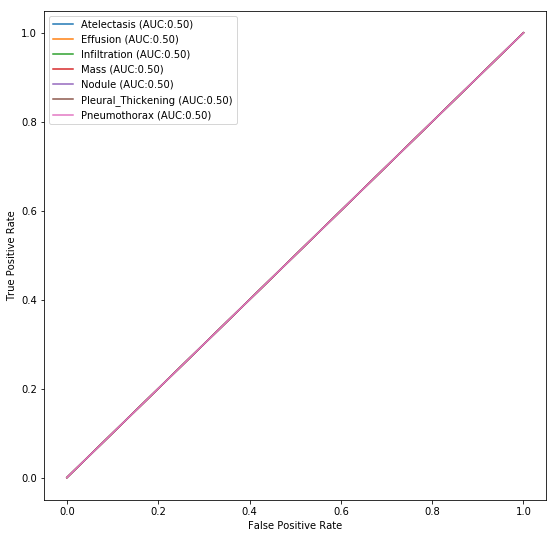

In [15]:
from sklearn.metrics import roc_curve, auc
fig, c_ax = plt.subplots(1,1, figsize = (9, 9))
for (idx, c_label) in enumerate(all_labels):
    fpr, tpr, thresholds = roc_curve(test_Y[:,idx].astype(int), pred_Y[:,idx])
    c_ax.plot(fpr, tpr, label = '%s (AUC:%0.2f)'  % (c_label, auc(fpr, tpr)))
c_ax.legend()
c_ax.set_xlabel('False Positive Rate')
c_ax.set_ylabel('True Positive Rate')
fig.savefig('barely_trained_net_sigmoid_128x128.png')